In [ ]:
#setup
!pip install tensorflow
!pip install tensorflow_io
!pip install soundfile

In [115]:
import tensorflow as tf
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow_hub as hub
import tensorflow_io as tfio
import soundfile as sf

In [18]:
#get yamnet model and test that it works

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [92]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    print(filename)
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [44]:
#show yamnets pretrained classes
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
    print(name)

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing


In [116]:
#convert all files to 16 bit WAV

# Path to the master dataset folder
master_dataset_folder = 'dataset'

# Iterate through all files in the master dataset
for root, _, files in os.walk(master_dataset_folder):
    for file in files:
        # Check if the file is a WAV file
        if file.endswith('.wav'):
            # Create the input and output file paths
            input_file = os.path.join(root, file)
            output_file = os.path.join(root, file.split('.wav')[0] + '.wav')
            
            # Load the audio file
            audio, sample_rate = sf.read(input_file)
            
            # Convert to 16-bit audio
            audio_16bit = (audio * (2 ** 15)).astype('int16')
            
            # Save as 16-bit WAV file
            sf.write(output_file, audio_16bit, sample_rate)

In [118]:
import random

# Path to the main folder containing subfolders with audio files
main_folder = 'dataset'

# List all subdirectories (classes)
subfolders = [f.path for f in os.scandir(main_folder) if f.is_dir()]

# Initialize an empty list to store the data
data = []

# Initialize a list to store fold assignments
fold_assignments = []

# Define the number of folds
num_folds = 5

my_classes  = []

# Iterate through each subfolder
for class_num, subfolder in enumerate(subfolders):
    class_name = os.path.basename(subfolder)
    my_classes.append(class_name)
    
    # List all audio files in the subfolder
    audio_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.wav')]
    
    # Shuffle the audio files
    random.seed(42)  # Set a random seed for reproducibility
    random.shuffle(audio_files)
    
    # Calculate the number of samples per fold
    samples_per_fold = len(audio_files) // num_folds
    
    # Assign folds to audio files
    for i, audio_file in enumerate(audio_files):
        relative_path =  os.path.join(main_folder, os.path.relpath(audio_file, main_folder))
        data.append([str(relative_path), class_name, class_num])
        
        # Determine the fold assignment for the current audio file
        fold_assignment = i // samples_per_fold
        fold_assignments.append(fold_assignment)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=['filename', 'class', 'target'])

# Add the 'Fold' column to the DataFrame
df['folds'] = fold_assignments

# Save the DataFrame to a CSV file
df.to_csv('audio_data.csv', index=False)
df


,filename,class,target,folds
0,dataset\Ambulance\sound_159.wav,Ambulance,0,0
1,dataset\Ambulance\sound_88.wav,Ambulance,0,0
2,dataset\Ambulance\sound_190.wav,Ambulance,0,0
3,dataset\Ambulance\sound_93.wav,Ambulance,0,0
4,dataset\Ambulance\sound_2.wav,Ambulance,0,0
...,...,...,...,...
793,dataset\Smoke alarm\345497__wjoojoo__smoke_ala...,Smoke alarm,6,4
794,dataset\Smoke alarm\345497__wjoojoo__smoke_ala...,Smoke alarm,6,4
795,dataset\Smoke alarm\345497__wjoojoo__smoke_ala...,Smoke alarm,6,4
796,dataset\Smoke alarm\345497__wjoojoo__smoke_ala...,Smoke alarm,6,4


In [119]:
#convert to tf Dataset

filenames = df['filename']
targets = df['target']
folds = df['folds']


main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

dataset\Ambulance\sound_159.wav


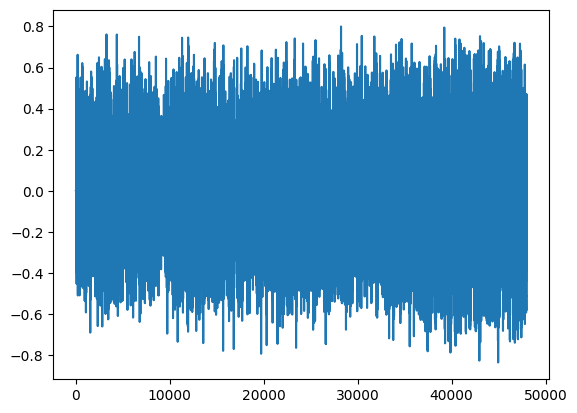

In [120]:
testing_wav_file_name = df['filename'][0]
print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [121]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Emergency vehicle
The embeddings shape: (6, 1024)


0      dataset\Ambulance\sound_159.wav
1       dataset\Ambulance\sound_88.wav
2      dataset\Ambulance\sound_190.wav
3       dataset\Ambulance\sound_93.wav
4        dataset\Ambulance\sound_2.wav
                    ...               
195    dataset\Ambulance\sound_162.wav
196      dataset\Ambulance\sound_9.wav
197    dataset\Ambulance\sound_104.wav
198    dataset\Ambulance\sound_124.wav
199     dataset\Ambulance\sound_66.wav
Name: filename, Length: 200, dtype: object

In [122]:
#load all the filenames in the dataframe into audio objects
def load_wav_for_map(filename, label, folds):
    print(filename)
    return load_wav_16k_mono(filename), label, folds

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Tensor("args_0:0", shape=(), dtype=string)


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [123]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [124]:
#see how folds are distributed

from collections import Counter
Counter(fold_assignments)

Counter({0: 158, 1: 158, 2: 158, 3: 158, 4: 158, 5: 8})

In [125]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 3)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold >= 4)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [126]:
my_classes

['Ambulance',
 'Burglary Alarm',
 'Fire alarm',
 'Fire truck',
 'Gunshots',
 'Silence',
 'Smoke alarm']

In [127]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 528,391
Trainable params: 528,391
Non-trainable params: 0
_________________________________________________________________


In [128]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [129]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
463/463 [==============================] - 146s 292ms/step - loss: 0.1663 - accuracy: 0.9800 - val_loss: 0.8814 - val_accuracy: 0.6631
Epoch 2/20
463/463 [==============================] - 2s 5ms/step - loss: 0.0691 - accuracy: 0.9863 - val_loss: 0.2843 - val_accuracy: 0.8909
Epoch 3/20
463/463 [==============================] - 2s 5ms/step - loss: 0.0438 - accuracy: 0.9901 - val_loss: 0.1257 - val_accuracy: 0.9481
Epoch 4/20
463/463 [==============================] - 2s 5ms/step - loss: 0.0461 - accuracy: 0.9889 - val_loss: 0.1600 - val_accuracy: 0.9407
Epoch 5/20
463/463 [==============================] - 2s 4ms/step - loss: 0.0456 - accuracy: 0.9889 - val_loss: 0.1385 - val_accuracy: 0.9388
Epoch 6/20
463/463 [==============================] - 2s 5ms/step - loss: 0.0427 - accuracy: 0.9897 - val_loss: 0.1545 - val_accuracy: 0.9375
Epoch 7/20
463/463 [==============================] - 2s 5ms/step - loss: 0.0408 - accuracy: 0.9884 - val_loss: 0.1720 - val_accuracy: 0.9388
Ep

In [130]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

128/128 [==============================] - 1s 6ms/step - loss: 0.1220 - accuracy: 0.9582
Loss:  0.12203102558851242
Accuracy:  0.958189845085144


dataset\Burglary Alarm\238562__odilonmarcenaro__arming-burglar-alarm-2 (61).wav


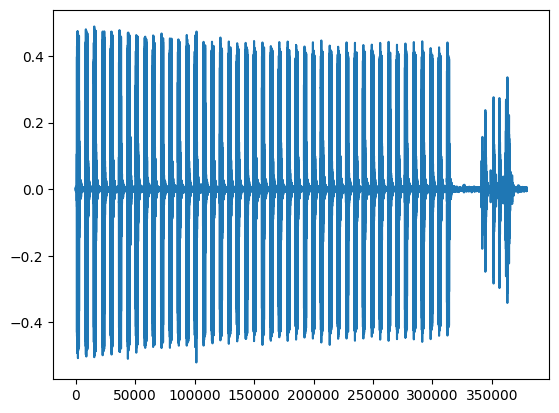

In [134]:
testing_wav_file_name = df['filename'][201]
print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)


In [135]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: Burglary Alarm


In [139]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)
    
saved_model_path = './audio_classifier'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./audio_classifier\assets


INFO:tensorflow:Assets written to: ./audio_classifier\assets


In [140]:
reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_results = reloaded_model(testing_wav_data)
my_classes[tf.math.argmax(reloaded_results)]

'Burglary Alarm'